In [1]:
%matplotlib inline
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import fpoffline.fvc

In [2]:
stacks = {
    20210610: list(range(93175, 93245)),
}

In [3]:
def stack_fvc(path, expids, ext='F0000', verbose=True):
    path = pathlib.Path(path)
    if not path.exists():
        raise ValueError('Invalid path: {path}')
    stack = np.zeros((6000,6000), np.float32)
    tot_exptime = 0
    for expid in expids:
        exptag = str(expid).zfill(8)
        filename = path / exptag / f'fvc-{exptag}.fits.fz'
        if not filename.exists():
            raise ValueError('Missing file: {filename}')
        hdr = fitsio.read_header(str(filename), ext=ext)
        tot_exptime += hdr.get('EXPTIME', 0)
        data = fitsio.read(str(filename), ext=ext)
        stack += data
    if verbose:
        print(f'Stacked {tot_exptime:.1f}s from {len(expids)} exposures.')
    return stack

In [4]:
DESI = pathlib.Path('/global/cfs/cdirs/desi')
DATA = DESI /  'spectro' / 'data'
assert DATA.exists()

In [5]:
coadds = { night: fpoffline.fvc.process_front_illuminated(stack_fvc(DATA / str(night), expids)) for night,expids in stacks.items() }

Stacked 700.0s from 70 exposures.


In [6]:
def generate(ngen, size=6000, seed=123):
    
    nights = np.array(list(stacks.keys()))
    data = np.empty((2, ngen, size, size), np.float32)
    fullsize = 6000

    # Pick a random night and exposure for each sample.
    rng = np.random.RandomState(seed)
    inights = rng.choice(len(nights), ngen, replace=True)
    expids = np.array([rng.choice(stacks[nights[i]], 1)[0] for i in inights])

    # Loop over nights used in sample.
    for inight in np.unique(inights):
        night = nights[inight]
        night_idx = np.where(inights == inight)[0]
        # Get the coadd for this night.
        coadd = coadds[night]
        # Loop over exposures from this night used in the sample.
        night_expids = expids[night_idx]        
        for expid in np.unique(night_expids):
            exp_idx = np.where(night_expids == expid)[0]
            igens = night_idx[exp_idx]
            # Read this single exposure.
            exptag = str(expid).zfill(8)
            filename = DATA / str(night) / exptag / f'fvc-{exptag}.fits.fz'
            print(night, expid, igens, filename)
            single = fpoffline.fvc.process_front_illuminated(fitsio.read(str(filename), ext='F0000'))
            for igen in igens:                
                # training input
                data[0,igen] = single
                # target output
                data[1,igen] = coadd
    return data

D = generate(1)

20210610 93241 [0] /global/cfs/cdirs/desi/spectro/data/20210610/00093241/fvc-00093241.fits.fz


In [7]:
import fpoffline.denoise
denoised_t = fpoffline.denoise.denoise_torch(D[0][0])

Using cuda device


In [8]:
denoised_np = fpoffline.denoise.denoise_numpy(D[0][0])

(-0.5, 5999.5, 5999.5, -0.5)

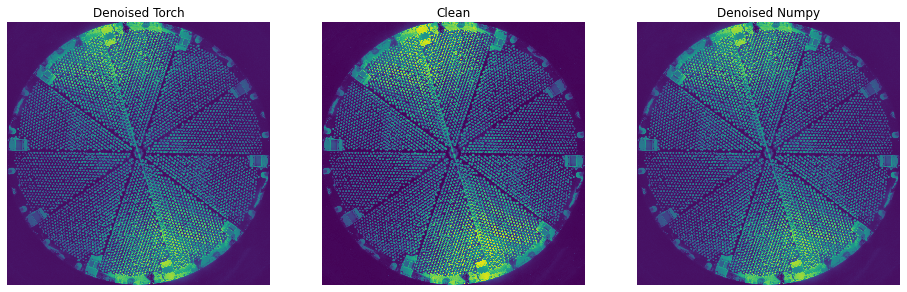

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(16, 12))
ax[0].imshow(denoised_t, origin='upper', interpolation='none')
ax[0].set_title('Denoised Torch')
ax[0].axis('off')
ax[1].imshow(D[1][0], origin='upper', interpolation='none')
ax[1].set_title('Clean')
ax[1].axis('off')
ax[2].imshow(denoised_np, origin='upper', interpolation='none')
ax[2].set_title('Denoised Numpy')
ax[2].axis('off')

(-0.5, 199.5, 199.5, -0.5)

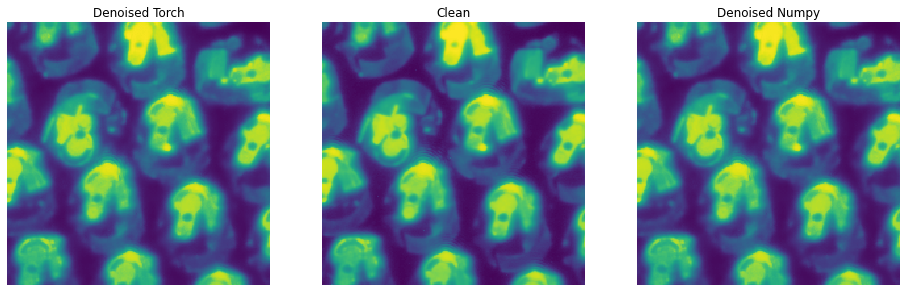

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 12))
ax[0].imshow(denoised_t[1200:1400,1200:1400], origin='upper', interpolation='none')
ax[0].set_title('Denoised Torch')
ax[0].axis('off')
ax[1].imshow(D[1][0][1200:1400,1200:1400], origin='upper', interpolation='none')
ax[1].set_title('Clean')
ax[1].axis('off')
ax[2].imshow(denoised_np[1200:1400,1200:1400], origin='upper', interpolation='none')
ax[2].set_title('Denoised Numpy')
ax[2].axis('off')